In [1]:
from mobility_service_model import MobilityModel
from activity_scheduler import ActivityScheduler
from mode_choice_nhts import NhtsModeLogit
from two_stage_logit_hlc import TwoStageLogitHLC
from cs_handler import CS_Handler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from copy import deepcopy
import pickle
import numpy as np
from functools import partial
from collections import Counter
import time
import matplotlib.pyplot as plt
import json

/Users/doorleyr/anaconda/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


## Functions 

In [2]:
def transfer_curves(dist, mode, cut=None, mode_names=None):
    dist = np.array(dist)
    mode = np.array(mode)
    if mode_names is None:
        mode_names = np.unique(mode)
    if cut is None:
        tmp_dist_cut_points = np.sort(dist)
    elif isinstance(cut, int):
        percentiles  = np.linspace(0, 100, num=cut)
        tmp_dist_cut_points = np.percentile(dist, percentiles)
    else:
        tmp_dist_cut_points = cut
    tmp_dist_cut_points = np.unique(tmp_dist_cut_points)
    counter_result = {mode_name: [] for mode_name in mode_names}
    ratio_result = {mode_name: [] for mode_name in mode_names}
    dist_cut_points = []   #in case that some cut points do not have any records
    for cut_idx in range(len(tmp_dist_cut_points)):
        if cut_idx == 0:
            this, last = tmp_dist_cut_points[0], -100
        else:
            this, last = tmp_dist_cut_points[cut_idx], tmp_dist_cut_points[cut_idx-1]
        dist_idx = np.where((dist<=this) & (dist>last))
        if len(dist_idx[0]) == 0:
            continue
        dist_cut_points.append(this)
        crt_counter = Counter(mode[dist_idx])
        for mode_name in mode_names:
            counter_result[mode_name].append(crt_counter[mode_name])
            ratio_result[mode_name].append(crt_counter[mode_name] / len(dist_idx[0]))
    return counter_result, ratio_result, dist_cut_points

## Initialize Mobility Model

In [3]:
this_model=MobilityModel('corktown', 'Detroit')
mode_choice_model=NhtsModeLogit(table_name='corktown', city_folder='Detroit')
this_model.assign_mode_choice_model(mode_choice_model)
this_model.assign_home_location_choice_model(
        TwoStageLogitHLC(table_name='corktown', city_folder='Detroit', 
                         geogrid=this_model.geogrid, 
                         base_vacant_houses=this_model.pop.base_vacant))
this_model.assign_activity_scheduler(ActivityScheduler(model=this_model))

from mobility_service_model import Population
base_sim_persons=json.load(open(this_model.SIM_POP_PATH))
large_base_sim_persons=[]
for person in base_sim_persons:
    large_base_sim_persons.extend([person.copy()]*10)
base_floating_persons=json.load(open(this_model.FLOATING_PATH))
base_vacant_housing=json.load(open(this_model.VACANT_PATH))
# this_model.pop=Population(base_sim_persons, base_floating_persons, base_vacant_housing, model=this_model)
this_model.pop=Population(large_base_sim_persons, base_floating_persons, base_vacant_housing, model=this_model)

this_model.activity_scheduler.assign_profiles(this_model.pop.base_sim)
for person in this_model.pop.base_sim:
    this_model.activity_scheduler.sample_activity_schedules(person, model=this_model)
this_model.create_trips(this_model.pop.base_sim)

# Simulation of baseline scenario before mode intervention using MNL, used for calc substitution pattern later
trial_model = deepcopy(this_model)
new_ASCs = {
#     'ASC for cycle': -0.9, 
    'ASC for PT': -0.9, 
#     'ASC for walk': 2.9
}
trial_model.mode_choice_model.set_logit_model_params(new_ASCs)
trial_model.predict_trip_modes(trial_model.pop.base_sim, method='random', seed=0)
mode_split_base = trial_model.get_mode_split(trial_model.pop.base_sim)

Building transport network
Building geography
Building synthetic population
	 Creating Trips
	 Predicting Trip modes
[True, 'NHB']
[True, 'HBO']
[True, 'NHB']
[True, 'NHB']
	 	 predicting
	 	 applying predictions to trips


## Specify New Modes 

In [4]:
micromobility_spec={'name': 'micromobility', 
                    'attrs':{'active_time_minutes': 'c*1+5',
                             'cost':0.2},  
                    'copy': 'cycle',
                    "copy_route": "cycling","activity": "cycling","speed_m_s": 4.167,
                    "co2_emissions_kg_met": 0,"fixed_costs": {},
                    'internal_net': 'active',
                    'availability': 'external_network_dist_mile<=1.5'
                   }
shuttle_spec={'name': 'shuttle', 
              'attrs':{'vehicle_time_minutes': 'd*1',
                       'active_time_minutes': 5,
                       'cost':5},  
              'copy': 'PT',
              "copy_route": "driving","activity": "pt","speed_m_s": 8.33,
              "co2_emissions_kg_met": 0.000066,"fixed_costs": {},
              'internal_net': 'pt',
              'availability': 'external_network_dist_mile<=3'
             }

new_mode_specs = [micromobility_spec, shuttle_spec]

The cell below is to check cost / active_time for new modes in logit long form data. For convenvience, the temp mode_choice_model used for prediction is saved as an attribute of mobility model in a draft version.

In [5]:
# mocho = trial_model.mode_choice_model
# mocho.long_data_df.head(12)

In [6]:
# for k,v in mocho.logit_model['params'].items():
#     print("{}: {}".format(k,v))

## Optimization 

In [7]:
## object function: returns the MAE between predicted and expected mode shares
def fobjective_new_modes(params, disp=False):
    """
    Arguments:
    ----------------------------------------------------------------------------
    params: dict of parameters as decision variables, need not to specify 
    """
    lambda_PT, lambda_walk = params['lambda_PT'], params['lambda_walk']
    beta_similarity_PT = params['beta_similarity_PT']
    ASC_bikeshare, ASC_shuttle = params['ASC_micromobility'], params['ASC_shuttle']
    nests_spec=[{'name': 'PT_like', 'alts':['micromobility', 'PT', 'shuttle'], 'lambda':lambda_PT},
                {'name': 'walk_like', 'alts':['micromobility','walk'], 'lambda':lambda_walk}
               ]
    trial_model.set_new_modes(new_mode_specs, nests_spec=nests_spec)
    new_beta_params = {}
    crt_logit_params = trial_model.mode_choice_model.logit_model['params']
    for g_attr in trial_model.mode_choice_model.logit_generic_attrs:
        new_beta_params['{} for micromobility'.format(g_attr)] = \
            crt_logit_params['{} for PT'.format(g_attr)] * beta_similarity_PT + \
            crt_logit_params['{} for walk'.format(g_attr)] * (1-beta_similarity_PT)
    new_beta_params['ASC for micromobility'] =  ASC_bikeshare
    new_beta_params['ASC for shuttle'] = ASC_shuttle
    persons = trial_model.pop.base_sim
    
    # new mode share
    trial_model.predict_trip_modes(persons, method='random', seed=0, logit_params=new_beta_params)
    mode_split_new = trial_model.get_mode_split(trial_model.pop.base_sim)
    
    # substitution pattern
    substitution = {mode: mode_split_base[mode]-mode_split_new[mode] for mode in ['driving', 'cycling', 'walking', 'pt']}
    total_substitution = sum(substitution.values())
    substitution_ratio = {}
    for mode, subs in substitution.items():
        if total_substitution != 0:
            substitution_ratio[mode] = subs/total_substitution
        else:
            substitution_ratio[mode] = 0
    
    # get subgroup trips
    trips_lt_1p5mile = []
    trips_lt_3mile = []
    for p in persons:
        for t in p.trips:
            if t.mode_choice_set['driving'].costs['driving']*30/60 <= 0: #excluded when generating all_trips
                continue
            external_dist = (t.mode_choice_set['walking'].pre_time+t.mode_choice_set['walking'].post_time)*0.041
            if external_dist <= 1.5:
                trips_lt_1p5mile.append(t)
                trips_lt_3mile.append(t)
            elif external_dist <= 3:
                trips_lt_3mile.append(t)
    counter_lt_1p5mile = Counter([t.mode.name for t in trips_lt_1p5mile])
    counter_lt_3mile = Counter([t.mode.name for t in trips_lt_3mile])
    
    # ~10% of trips with external distance < 1.5 miles should be by micro mobility
    micromobility_share_for_trips_lt_1ptmile = counter_lt_1p5mile['micromobility'] / len(trips_lt_1p5mile)
    loss_micromobility = np.abs(micromobility_share_for_trips_lt_1ptmile - 0.1)
    
    # ~20% of trips with external distance < 3 miles should be by on-demand shuttle
    shuttle_share_for_trips_lt_3mile = counter_lt_3mile['shuttle'] / len(trips_lt_3mile)
    loss_shuttle = np.abs(shuttle_share_for_trips_lt_3mile - 0.2)
    
    # total loss: add other loss if neccessary
    loss = loss_micromobility * 0.5 + loss_shuttle * 0.5
    if any([abs(share)<1e-10 for share in mode_split_new.values()]): loss += 1000  # prevent share of any mode = 0 
        
    if disp:
        print('\n\nResults: \n'+'-'*30)
        print('Total mode share: ')
        for k,v in  mode_split_new.items(): print('   {}: {:4.4f}'.format(k,v))
        print('Substitution pattern: ')
        for k,v in substitution_ratio.items(): print('   {}: {:4.4f}'.format(k,v))
        print('Micromobility share for trips with external distance < 1.5miles: ', micromobility_share_for_trips_lt_1ptmile)
        print('Shuttle share for trips with external distance < 3miles: ', shuttle_share_for_trips_lt_3mile)
    
    return {'loss': loss, 'status': STATUS_OK}

In [8]:
## set search space 
fspace = {
    'lambda_PT': hp.uniform('lambda_PT', 0.05, 0.95),
    'lambda_walk': hp.uniform('lambda_walk', 0.05, 0.95),
    'beta_similarity_PT':hp.uniform('beta_similarity_PT', 0, 1),
    'ASC_micromobility': hp.uniform('ASC_micromobility',-10, 10),
    'ASC_shuttle': hp.uniform('ASC_shuttle', -10, 10)
}


## fit
trials = Trials()
best = fmin(fn = partial(fobjective_new_modes), 
            space=fspace, algo=tpe.suggest, max_evals=500, trials=trials)

	 Predicting Trip modes                                
[True, 'NHB']                                          
[True, 'HBO']                                          
[True, 'NHB']                                          
[True, 'NHB']                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0
	 	 predicting                                         
parse:                                                 
[('external_network_dist_mile', '<=1.5')]              
parse:                                                 
[('external_network_dist_mile', '<=3')]                
	 	 applying predictions to trips                      
	 Predicting Trip modes                                                            
[True, 'NHB']                                                                      
[True, 'HBO']                                                                      
[True, 'NHB']                                             

	 	 predicting                                                                      
parse:                                                                              
[('external_network_dist_mile', '<=1.5')]                                           
parse:                                                                              
[('external_network_dist_mile', '<=3')]                                             
	 	 applying predictions to trips                                                   
	 Predicting Trip modes                                                             
[True, 'NHB']                                                                       
[True, 'HBO']                                                                       
[True, 'NHB']                                                                       
[True, 'NHB']                                                                       
[warning] no information for micromobility_vehicle_time_minutes, 

[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                         

[True, 'NHB']                                                                       
[warning] no information for micromobility_vehicle_time_minutes, set to 0           
	 	 predicting                                                                      
parse:                                                                              
[('external_network_dist_mile', '<=1.5')]                                           
parse:                                                                              
[('external_network_dist_mile', '<=3')]                                             
	 	 applying predictions to trips                                                   
	 Predicting Trip modes                                                             
[True, 'NHB']                                                                       
[True, 'HBO']                                                                       
[True, 'NHB']                                                    

[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                         

[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                         

[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                               

	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                     

	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]               

[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                

parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                                               
[('external_network_dist_mile', '<=1.5')]             

[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                                                       
parse:                                                

parse:                                                                               
[('external_network_dist_mile', '<=1.5')]                                            
parse:                                                                               
[('external_network_dist_mile', '<=3')]                                              
	 	 applying predictions to trips                                                    
	 Predicting Trip modes                                                              
[True, 'NHB']                                                                        
[True, 'HBO']                                                                        
[True, 'NHB']                                                                        
[True, 'NHB']                                                                        
[warning] no information for micromobility_vehicle_time_minutes, set to 0            
	 	 predicting                                        

[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                              

[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                              

[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                    

	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]    

parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]  

parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                             

[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                              

[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                              

[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                    

	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]    

parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]  

parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                             

[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                                                                         
[True, 'NHB']                                                                         
[True, 'NHB']                              

[True, 'NHB']                                                                         
[True, 'NHB']                                                                         
[warning] no information for micromobility_vehicle_time_minutes, set to 0             
	 	 predicting                                                                        
parse:                                                                                
[('external_network_dist_mile', '<=1.5')]                                             
parse:                                                                                
[('external_network_dist_mile', '<=3')]                                               
	 	 applying predictions to trips                                                     
	 Predicting Trip modes                                                               
[True, 'NHB']                                                                         
[True, 'HBO']                              

	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trip

parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', 

	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for mic

[True, 'NHB']                                                                            
[True, 'HBO']                                                                            
[True, 'NHB']                                                                            
[True, 'NHB']                                                                            
[warning] no information for micromobility_vehicle_time_minutes, set to 0                
	 	 predicting                                                                           
parse:                                                                                   
[('external_network_dist_mile', '<=1.5')]                                                
parse:                                                                                   
[('external_network_dist_mile', '<=3')]                                                  
	 	 applying predictions to trips                                                        
	 Predicti

[('external_network_dist_mile', '<=1.5')]                                                
parse:                                                                                   
[('external_network_dist_mile', '<=3')]                                                  
	 	 applying predictions to trips                                                        
	 Predicting Trip modes                                                                  
[True, 'NHB']                                                                            
[True, 'HBO']                                                                            
[True, 'NHB']                                                                            
[True, 'NHB']                                                                            
[warning] no information for micromobility_vehicle_time_minutes, set to 0                
	 	 predicting                                                                           
parse:    

[True, 'NHB']                                                                            
[True, 'NHB']                                                                            
[warning] no information for micromobility_vehicle_time_minutes, set to 0                
	 	 predicting                                                                           
parse:                                                                                   
[('external_network_dist_mile', '<=1.5')]                                                
parse:                                                                                   
[('external_network_dist_mile', '<=3')]                                                  
	 	 applying predictions to trips                                                        
	 Predicting Trip modes                                                                  
[True, 'NHB']                                                                            
[True, 'HB

[('external_network_dist_mile', '<=3')]                                                  
	 	 applying predictions to trips                                                        
	 Predicting Trip modes                                                                  
[True, 'NHB']                                                                            
[True, 'HBO']                                                                            
[True, 'NHB']                                                                            
[True, 'NHB']                                                                            
[warning] no information for micromobility_vehicle_time_minutes, set to 0                
	 	 predicting                                                                           
parse:                                                                                   
[('external_network_dist_mile', '<=1.5')]                                                
parse:    

[warning] no information for micromobility_vehicle_time_minutes, set to 0                
	 	 predicting                                                                           
parse:                                                                                   
[('external_network_dist_mile', '<=1.5')]                                                
parse:                                                                                   
[('external_network_dist_mile', '<=3')]                                                  
	 	 applying predictions to trips                                                        
	 Predicting Trip modes                                                                  
[True, 'NHB']                                                                            
[True, 'HBO']                                                                            
[True, 'NHB']                                                                            
[True, 'NH

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                  

[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                   

[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                                                                                 
[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes         

[('external_network_dist_mile', '<=3')]                                                
	 	 applying predictions to trips                                                      
	 Predicting Trip modes                                                                
[True, 'NHB']                                                                          
[True, 'HBO']                                                                          
[True, 'NHB']                                                                          
[True, 'NHB']                                                                          
[warning] no information for micromobility_vehicle_time_minutes, set to 0              
	 	 predicting                                                                         
parse:                                                                                 
[('external_network_dist_mile', '<=1.5')]                                              
parse:                          

## Check Performance 

In [9]:
for k,v in best.items():
    print('{}: {}'.format(k,v))
fobjective_new_modes(best, disp=True)

ASC_micromobility: 2.634610546999314
lambda_walk: 0.29000037791673317
ASC_shuttle: 2.3333053005100015
beta_similarity_PT: 0.4961003449493877
lambda_PT: 0.6520296474799678
	 Predicting Trip modes
[True, 'NHB']
[True, 'HBO']
[True, 'NHB']
[True, 'NHB']
[warning] no information for micromobility_vehicle_time_minutes, set to 0
	 	 predicting
parse:  [('external_network_dist_mile', '<=1.5')]
parse:  [('external_network_dist_mile', '<=3')]
	 	 applying predictions to trips


Results: 
------------------------------
Total mode share: 
   cycling: 0.0104
   driving: 0.8380
   pt: 0.0015
   shuttle: 0.0733
   walking: 0.0462
   micromobility: 0.0305
Substitution pattern: 
   pt: 0.0999
   cycling: 0.0169
   walking: 0.4249
   driving: 0.4583
Micromobility share for trips with external distance < 1.5miles:  0.10503472222222222
Shuttle share for trips with external distance < 3miles:  0.19012675116744496


{'loss': 0.007453985527388636, 'status': 'ok'}

In [10]:
best

{'ASC_micromobility': 2.634610546999314,
 'ASC_shuttle': 2.3333053005100015,
 'beta_similarity_PT': 0.4961003449493877,
 'lambda_PT': 0.6520296474799678,
 'lambda_walk': 0.29000037791673317}

In [11]:
# manual = best.copy()
# manual = {}
# manual['ASC_micromobility'] = 2.8
# manual['ASC_shuttle'] = 2.75
# manual['beta_similarity_PT'] =0.45
# manual['lambda_PT']=0.7
# manual['lambda_walk']=0.4
manual = {}
manual['ASC_micromobility'] = 2.63
manual['ASC_shuttle'] = 2.33
manual['beta_similarity_PT'] =0.5
manual['lambda_PT']=0.65
manual['lambda_walk']=0.29


for k,v in manual.items():
    print('{}: {}'.format(k,v))
fobjective_new_modes(manual, disp=True)

ASC_micromobility: 2.63
lambda_walk: 0.29
beta_similarity_PT: 0.49
lambda_PT: 0.65
ASC_shuttle: 2.33
	 Predicting Trip modes
[True, 'NHB']
[True, 'HBO']
[True, 'NHB']
[True, 'NHB']
[warning] no information for micromobility_vehicle_time_minutes, set to 0
	 	 predicting
parse:  [('external_network_dist_mile', '<=1.5')]
parse:  [('external_network_dist_mile', '<=3')]
	 	 applying predictions to trips


Results: 
------------------------------
Total mode share: 
   cycling: 0.0103
   driving: 0.8379
   pt: 0.0015
   shuttle: 0.0730
   walking: 0.0468
   micromobility: 0.0305
Substitution pattern: 
   pt: 0.1002
   cycling: 0.0183
   walking: 0.4201
   driving: 0.4615
Micromobility share for trips with external distance < 1.5miles:  0.10503472222222222
Shuttle share for trips with external distance < 3miles:  0.1894596397598399


{'loss': 0.007787541231191165, 'status': 'ok'}

In [12]:
people = trial_model.pop.base_sim
external_dist_list, mode_list = [], []
skip = 0
for person in people:
    for trip in person.trips:
        if trip.mode_choice_set['driving'].costs['driving']*30/60 <= 0: #excluded when generating all_trips
            skip += 1
            continue
        external_dist = (trip.mode_choice_set['walking'].pre_time+trip.mode_choice_set['walking'].post_time)*0.041
        external_dist_list.append(external_dist)
        mode_list.append(trip.mode.name)

dist_cut_points = np.percentile(external_dist_list, np.linspace(0, 100, num=10)) 
dist_cut_points = np.append(dist_cut_points, [1.5, 3])
counter_result, ratio_result, dist_cut_points = transfer_curves(external_dist_list, mode_list,cut=dist_cut_points)
print('Skip {} trips with no distance'.format(skip))

Skip 4 trips with no distance


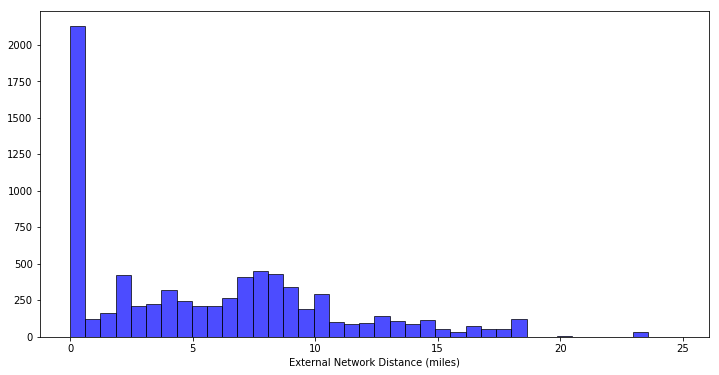

In [13]:
plt.figure(figsize=(12,6))
plt.hist(external_dist_list, bins=40, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("External Network Distance (miles)")
plt.show()

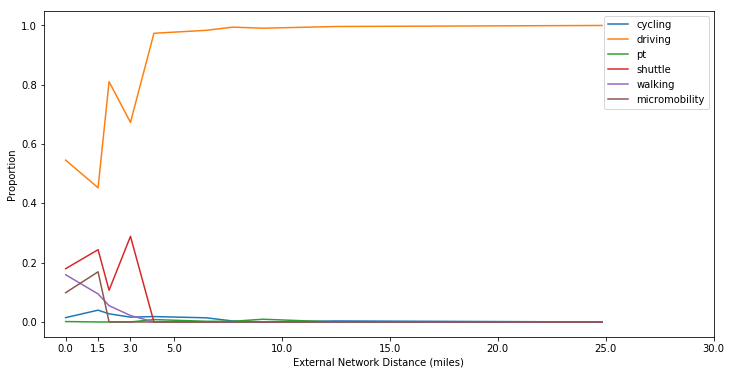

In [14]:
plt.figure(figsize=(12,6))
for mode_name in ratio_result:
    plt.plot(dist_cut_points, ratio_result[mode_name], label=mode_name)
plt.legend()
plt.xlabel("External Network Distance (miles)")
plt.ylabel("Proportion")
ax = plt.gca()
xticks = ax.get_xticks()
xticks = np.append(xticks, [1.5, 3])
ax.set_xticks(xticks)
ax.set_xlim([-1, xticks.max()])
plt.show()